In [53]:
# !pip install torch
# !pip install torchvision

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [55]:
# VAE Architecture 
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        x_flat = x.view(-1, self.input_dim)
        h1 = torch.relu(self.fc1(x_flat))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        mu, logvar = self.encode(x_flat)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [56]:
# Convolutional VAE Architecture (for CIFAR-10: 3x32x32 images)
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128, in_channels=3):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder: 32 -> 16 -> 8 -> 4 -> 2
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1),   # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),            # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),           # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),          # 4x4 -> 2x2
            nn.ReLU(),
        )
        self.enc_fc = nn.Linear(256 * 2 * 2, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 256 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 4, 2, 1),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        h = torch.relu(self.enc_fc(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.dec_fc(z))
        h = h.view(h.size(0), 256, 2, 2)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# ConvVAE for 64x64 images (Task 3)
class ConvVAE64(nn.Module):
    def __init__(self, latent_dim=256, in_channels=3):
        super(ConvVAE64, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1),
            nn.ReLU(), nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(), nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(256, 256, 4, 2, 1), nn.ReLU(),
        )
        self.enc_fc = nn.Linear(256 * 2 * 2, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        self.dec_fc = nn.Linear(latent_dim, 256 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(), nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 4, 2, 1), nn.Sigmoid(),
        )
    def encode(self, x):
        h = self.encoder(x).view(x.size(0), -1)
        h = torch.relu(self.enc_fc(h))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar); eps = torch.randn_like(std); return mu + eps * std
    def decode(self, z):
        h = torch.relu(self.dec_fc(z)).view(z.size(0), 256, 2, 2)
        return self.decoder(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        return self.decode(self.reparameterize(mu, logvar)), mu, logvar

In [58]:
# loss func
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    recon_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    BCE = nn.functional.binary_cross_entropy(recon_flat, x_flat, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

def train_with_annealing(model, train_loader, optimizer, epoch, total_epochs, anneal_epochs=5):
    """Train with KL annealing: beta goes 0->1 over first anneal_epochs to prevent posterior collapse."""
    model.train()
    train_loss = 0
    beta = min(1.0, epoch / anneal_epochs) if anneal_epochs > 0 else 1.0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}, beta: {beta:.2f}')


In [29]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [30]:
# Load MNIST dataset and run the training
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)


Epoch 1, Loss: 165.9919386393229
Epoch 2, Loss: 121.26936494140625
Epoch 3, Loss: 114.39743414713541
Epoch 4, Loss: 111.49512952473958
Epoch 5, Loss: 109.72425971679688
Epoch 6, Loss: 108.52966678059896
Epoch 7, Loss: 107.71731015625
Epoch 8, Loss: 107.12931240234376
Epoch 9, Loss: 106.56615240885417
Epoch 10, Loss: 106.13703255208334


## Task 1: Convolutional VAE on CIFAR-10

In [31]:
# Load CIFAR-10 and train fully connected VAE (for comparison with ConvVAE)
CIFAR_TRANSFORM = transforms.ToTensor()
cifar_train = datasets.CIFAR10('./data', train=True, download=True, transform=CIFAR_TRANSFORM)
cifar_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)

# Fully connected VAE for CIFAR-10: 32*32*3 = 3072 input dimension
vae_fc_cifar = VAE(input_dim=3072, hidden_dim=400, latent_dim=128)
optimizer_fc = optim.Adam(vae_fc_cifar.parameters(), lr=1e-3)

print("Training FC VAE on CIFAR-10...")
for epoch in range(1, 11):
    train(vae_fc_cifar, cifar_loader, optimizer_fc, epoch)

Files already downloaded and verified
Training FC VAE on CIFAR-10...
Epoch 1, Loss: 1981.455988125
Epoch 2, Loss: 1912.01776375
Epoch 3, Loss: 1891.27912125
Epoch 4, Loss: 1880.5917465625
Epoch 5, Loss: 1870.9776809375
Epoch 6, Loss: 1865.1485628125
Epoch 7, Loss: 1861.2769975
Epoch 8, Loss: 1857.59635875
Epoch 9, Loss: 1855.7645015625
Epoch 10, Loss: 1854.399994375


In [32]:
# convolutional VAE on CIFAR-10
conv_vae = ConvVAE(latent_dim=128, in_channels=3)
optimizer_conv = optim.Adam(conv_vae.parameters(), lr=1e-3)

print("Training ConvVAE on CIFAR-10...")
for epoch in range(1, 11):
    train(conv_vae, cifar_loader, optimizer_conv, epoch)

Training ConvVAE on CIFAR-10...
Epoch 1, Loss: 1983.759058125
Epoch 2, Loss: 1912.9450321875
Epoch 3, Loss: 1889.424150625
Epoch 4, Loss: 1875.05728875
Epoch 5, Loss: 1863.672808125
Epoch 6, Loss: 1857.4094571875
Epoch 7, Loss: 1853.870715625
Epoch 8, Loss: 1851.215793125
Epoch 9, Loss: 1849.22344
Epoch 10, Loss: 1847.55970375


In [33]:
def generate_images_cifar(model, num_images=8, latent_dim=128, is_conv=True):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim)
        generated = model.decode(z).cpu()
    if is_conv:
        generated = generated.permute(0, 2, 3, 1)
    else:
        generated = generated.view(num_images, 3, 32, 32).permute(0, 2, 3, 1)
    return generated.clamp(0, 1).numpy()

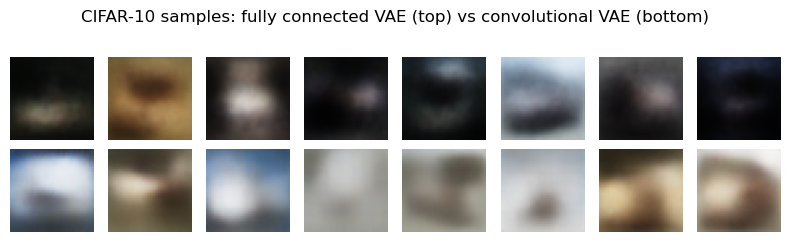

In [34]:
# compare generated images
import matplotlib.pyplot as plt

num_show = 8
fig, axes = plt.subplots(2, num_show, figsize=(num_show, 2.5))

fc_images = generate_images_cifar(vae_fc_cifar, num_images=num_show, latent_dim=128, is_conv=False)
conv_images = generate_images_cifar(conv_vae, num_images=num_show, latent_dim=128, is_conv=True)

for i in range(num_show):
    axes[0, i].imshow(fc_images[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(conv_images[i])
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('FC VAE', fontsize=11)
axes[1, 0].set_ylabel('ConvVAE', fontsize=11)
plt.suptitle('CIFAR-10 samples: fully connected VAE (top) vs convolutional VAE (bottom)', fontsize=12)
plt.tight_layout()
plt.show()

### Question 1 Comparison

In general, the two rows of images aren't spectacularly diffent, however, we can see that the bottom row corresponding to the convolutional VAE is slightly clearer and more coherent than the fully connected VAE (not by much!). Because the convolutional VAE perserves spatial structure via convolutional layers, the local patterns and edges are learned more effectively while the fully connected VAE flattens the image to a vector and loses the spatial relationships.



## Task 2: Latent space interpolation

In [35]:
def interpolate_latent(model, img1, img2, num_steps=10):
    model.eval()
    if img1.dim() == 3:
        img1, img2 = img1.unsqueeze(0), img2.unsqueeze(0)
    with torch.no_grad():
        mu1, _ = model.encode(img1)
        mu2, _ = model.encode(img2)
        # Linear interpolation in latent space
        alphas = torch.linspace(0, 1, num_steps + 2)
        images = []
        for alpha in alphas:
            z = (1 - alpha) * mu1 + alpha * mu2
            out = model.decode(z)
            images.append(out.cpu())
        return images

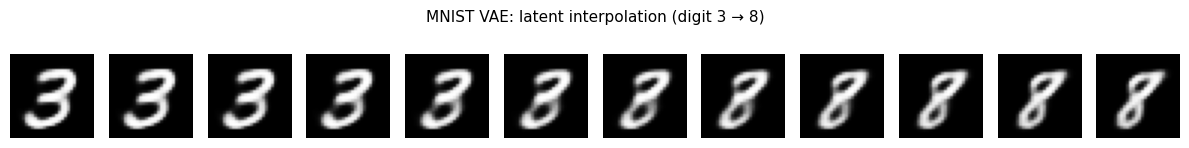

In [ ]:
# pick two images of diff digits
num_steps = 10
digits_a, digits_b = 3, 8
train_data = train_loader.dataset
idx_a = next(i for i, (_, y) in enumerate(train_data) if y == digits_a)
idx_b = next(i for i, (_, y) in enumerate(train_data) if y == digits_b)
img_a = train_data[idx_a][0].unsqueeze(0)
img_b = train_data[idx_b][0].unsqueeze(0)

interp_list = interpolate_latent(vae, img_a, img_b, num_steps=num_steps)
n = len(interp_list)
fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
for i, recon in enumerate(interp_list):
    axes[i].imshow(recon[0].view(28, 28).numpy(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'MNIST VAE: latent interpolation (digit {digits_a} → {digits_b})', fontsize=11)
plt.tight_layout()
plt.show()

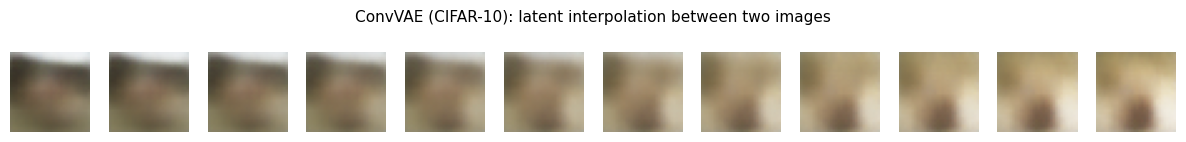

In [ ]:
# interpolation with ConvVAE on CIFAR-10 & pick two images from the training set
cifar_iter = iter(cifar_loader)
cbatch1, _ = next(cifar_iter)
cbatch2, _ = next(cifar_iter)
cifar_a = cbatch1[0:1]
cifar_b = cbatch2[0:1]

interp_cifar = interpolate_latent(conv_vae, cifar_a, cifar_b, num_steps=num_steps)
n = len(interp_cifar)
fig, axes = plt.subplots(1, n, figsize=(n, 1.4))
for i, recon in enumerate(interp_cifar):
    im = recon[0].permute(1, 2, 0).clamp(0, 1).numpy()
    axes[i].imshow(im)
    axes[i].axis('off')
plt.suptitle('ConvVAE (CIFAR-10): latent interpolation between two images', fontsize=11)
plt.tight_layout()
plt.show()

## Task 3: VAE on a new dataset

Training on **Oxford-IIIT Pets** (37 pet breeds, ~7.4k images).

In [59]:
# load Oxford-IIIT Pets
pet_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

pet_train = datasets.OxfordIIITPet('./data', split='trainval', target_types='category',
                                       transform=pet_transform, download=True)
pet_loader = torch.utils.data.DataLoader(pet_train, batch_size=64, shuffle=True)

In [60]:
# train ConvVAE on Oxford-IIIT Pets
vae_pets = ConvVAE64(latent_dim=256, in_channels=3)
optimizer_pets = optim.Adam(vae_pets.parameters(), lr=1e-3)

print("Training ConvVAE64 on Oxford-IIIT Pets (KL annealing, 25 epochs)...")
for epoch in range(1, 26):
    train_with_annealing(vae_pets, pet_loader, optimizer_pets, epoch, total_epochs=25, anneal_epochs=10)

Training ConvVAE64 on Oxford-IIIT Pets (KL annealing, 25 epochs)...
Epoch 1, Loss: 8369.7957, beta: 0.10
Epoch 2, Loss: 7968.3404, beta: 0.20
Epoch 3, Loss: 7727.5869, beta: 0.30
Epoch 4, Loss: 7628.9024, beta: 0.40
Epoch 5, Loss: 7566.8501, beta: 0.50
Epoch 6, Loss: 7574.2944, beta: 0.60
Epoch 7, Loss: 7562.9283, beta: 0.70
Epoch 8, Loss: 7554.4881, beta: 0.80
Epoch 9, Loss: 7526.2142, beta: 0.90
Epoch 10, Loss: 7498.9570, beta: 1.00
Epoch 11, Loss: 7480.3215, beta: 1.00
Epoch 12, Loss: 7465.1879, beta: 1.00
Epoch 13, Loss: 7454.2969, beta: 1.00
Epoch 14, Loss: 7440.3567, beta: 1.00
Epoch 15, Loss: 7431.1011, beta: 1.00
Epoch 16, Loss: 7432.5105, beta: 1.00
Epoch 17, Loss: 7417.0944, beta: 1.00
Epoch 18, Loss: 7409.7331, beta: 1.00
Epoch 19, Loss: 7395.9654, beta: 1.00
Epoch 20, Loss: 7382.0644, beta: 1.00
Epoch 21, Loss: 7369.4915, beta: 1.00
Epoch 22, Loss: 7362.2056, beta: 1.00
Epoch 23, Loss: 7354.8159, beta: 1.00
Epoch 24, Loss: 7351.0208, beta: 1.00
Epoch 25, Loss: 7347.6381, be

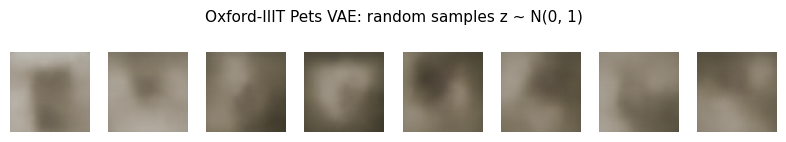

In [61]:
vae_pets.eval()
n_samples = 8
with torch.no_grad():
    z = torch.randn(n_samples, 256)
    gen = vae_pets.decode(z).cpu().permute(0, 2, 3, 1).clamp(0, 1).numpy()

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples, 1.4))
for i in range(n_samples):
    axes[i].imshow(gen[i])
    axes[i].axis('off')
plt.suptitle('Oxford-IIIT Pets VAE: random samples z ~ N(0, 1)', fontsize=11)
plt.tight_layout()
plt.show()

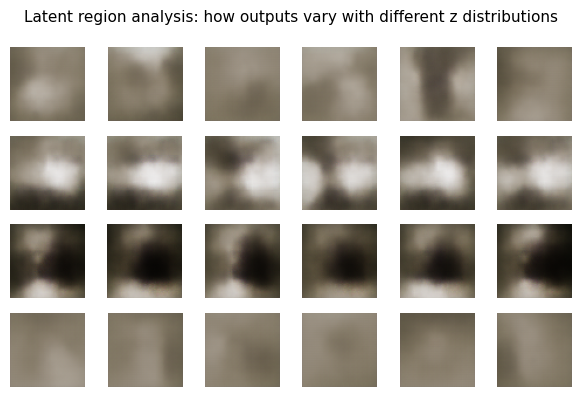

In [62]:
# sample from different regions of the latent space
vae_pets.eval()
latent_dim = 256
n_per_region = 6

fig, axes = plt.subplots(4, n_per_region, figsize=(n_per_region, 4))
regions = [
    (0., 1., 'z ~ N(0, 1) — standard'),
    (2., 1., 'z ~ N(2, 1) — positive bias'),
    (-2., 1., 'z ~ N(-2, 1) — negative bias'),
    (0., 0.5, 'z ~ N(0, 0.5) — low variance'),
]
with torch.no_grad():
    for row, (mu, std, label) in enumerate(regions):
        z = mu + std * torch.randn(n_per_region, latent_dim)
        gen = vae_pets.decode(z).cpu().permute(0, 2, 3, 1).clamp(0, 1).numpy()
        for col in range(n_per_region):
            axes[row, col].imshow(gen[col])
            axes[row, col].axis('off')
        axes[row, 0].set_ylabel(label, fontsize=9)
plt.suptitle('Latent region analysis: how outputs vary with different z distributions', fontsize=11)
plt.tight_layout()
plt.show()

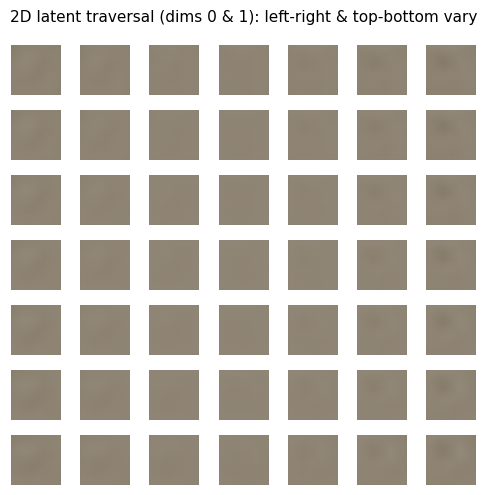

In [63]:
# 2d latent traversal: vary two dimensions while keeping the rest fixed at 0
vae_pets.eval()
latent_dim = 256
n_steps = 7
d1, d2 = 0, 1  # dimensions to vary (-3 to 3)

z_base = torch.zeros(1, latent_dim)
grid = []
for v1 in torch.linspace(-3, 3, n_steps):
    row = []
    for v2 in torch.linspace(-3, 3, n_steps):
        z = z_base.clone()
        z[0, d1], z[0, d2] = v1, v2
        with torch.no_grad():
            img = vae_pets.decode(z).cpu().permute(0, 2, 3, 1).clamp(0, 1).numpy()[0]
        row.append(img)
    grid.append(row)

fig, axes = plt.subplots(n_steps, n_steps, figsize=(5, 5))
for i in range(n_steps):
    for j in range(n_steps):
        axes[i, j].imshow(grid[i][j])
        axes[i, j].axis('off')
plt.suptitle(f'2D latent traversal (dims {d1} & {d2}): left-right & top-bottom vary', fontsize=11)
plt.tight_layout()
plt.show()

**Analysis:** 
- N(0, 1): Baseline samples from the prior; diverse, natural-looking pets.
- N(2, 1) / N(-2, 1): Large shifts in mean push the decoder into regions it rarely saw during training; outputs are blurry and distorted. The model extrapolates rather than interpolates but the images do slightly resemble pets if you squint and imagine that there may be dogs there.
- N(0, 0.5): Lower variance has less detailed images but still has the essence of the previous images.
- 2D traversal: Varying two latent dimensions causes essentially the same blank squares for all the images.

In [38]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].view(28, 28), cmap='gray')
        axs[i].axis('off')
    plt.show()




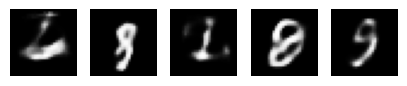

In [64]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 20
generate_images(vae, num_images=5, latent_dim=20)